# Flight Price Data Analysis with DuckDB

This notebook analyzes flight price data from `all_routes.csv` using **DuckDB** for SQL operations and creates visualizations to identify pricing patterns and insights.

## Analysis Goals:
- **OTA (Online Travel Agency)** price comparison and analysis
- Identify cheapest/most expensive routes
- Date based pricing trends analysis
- Create visualizations for actionable insights


## Environment Setup and DuckDB Installation


In [11]:
# Check and install DuckDB if needed
import sys
import subprocess

def install_duckdb():
    try:
        import duckdb
        print(" DuckDB is already installed!")
        print(f"DuckDB version: {duckdb.__version__}")
    except ImportError:
        print(" Installing DuckDB...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "duckdb"])
        import duckdb
        print(" DuckDB successfully installed!")
        print(f"DuckDB version: {duckdb.__version__}")

install_duckdb()

# Import other required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(" Flight Price Analysis - Multi Snapshot Time Series")
print("=" * 60)

# Setup paths and data discovery
snapshots_dir = Path("snapshots")
available_snapshots = [d.name for d in snapshots_dir.iterdir() if d.is_dir()]
available_snapshots.sort()

print(f"📅 Available snapshots: {available_snapshots}")
print(f"📊 Snapshot count: {len(available_snapshots)}")

# Load all snapshots for time series analysis
all_data = []
for snapshot_date in available_snapshots:
    snapshot_path = snapshots_dir / snapshot_date / "all_routes.csv"
    if snapshot_path.exists():
        df = pd.read_csv(snapshot_path)
        df['snapshot_date'] = snapshot_date
        all_data.append(df)
        print(f"   ✅ Loaded {snapshot_date}: {len(df)} records")

if all_data:
    # Combine all snapshots
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"\n Combined dataset: {len(combined_df)} total records")
    print(f" Date range: {combined_df['snapshot_date'].min()} → {combined_df['snapshot_date'].max()}")
else:
    print(" No snapshot data found")

# Initialize DuckDB connection
conn = duckdb.connect(':memory:')

if all_data:
    # Register the combined dataframe with DuckDB
    conn.register('flights', combined_df)
    print(f" DuckDB connection established with {len(combined_df)} records")

 DuckDB is already installed!
DuckDB version: 1.2.0
 Flight Price Analysis - Multi Snapshot Time Series
📅 Available snapshots: ['20250618', '20250619']
📊 Snapshot count: 2
   ✅ Loaded 20250618: 195 records
   ✅ Loaded 20250619: 193 records

 Combined dataset: 388 total records
 Date range: 20250618 → 20250619
 DuckDB connection established with 388 records


## Data Loading and Initial Exploration

Let me check if the `all_routes.csv` file exists and explore the dataset structure.

In [12]:
import os          
import pandas as pd 
from IPython.display import display  

# Checkpoint for CSV file existence
csv_file = "all_routes.csv"

if os.path.exists(csv_file):
    print(f"✅ Found {csv_file}!")
    
    # Quick preview with pandas
    df_preview = pd.read_csv(csv_file)
    print(f"\n📊 Dataset Overview:")
    print(f"   • Total rows: {len(df_preview):,}")
    print(f"   • Total columns: {len(df_preview.columns)}")
    print(f"\n📋 Columns:")
    for col in df_preview.columns:
        print(f"   • {col}")
    
    print(f"\n👀 First 5 rows:")
    display(df_preview.head())
    
    print(f"\n📈 Basic Statistics:")
    display(df_preview.describe())
    
    print("📊 TIME-SERIES DATASET OVERVIEW")
    print("=" * 50)

    # Basic statistics across all snapshots
    basic_stats = conn.execute("""
        SELECT 
            snapshot_date,
            COUNT(*) as flight_count,
            ROUND(AVG(price_eur), 2) as avg_price,
            MIN(price_eur) as min_price,
            MAX(price_eur) as max_price,
            COUNT(DISTINCT gate) as unique_otas,
            COUNT(DISTINCT CONCAT(origin, '-', destination)) as unique_routes
        FROM flights 
        GROUP BY snapshot_date
        ORDER BY snapshot_date
    """).df()

    display(basic_stats)

    print("\n📈 Basic Statistics:")
    print(f"   • Total flight records: {len(combined_df):,}")
    print(f"   • Unique routes monitored: {combined_df['origin'].str.cat(combined_df['destination'], sep=' → ').nunique()}")
    print(f"   • Active OTAs: {combined_df['gate'].nunique()}")
    print(f"   • Price range: €{combined_df['price_eur'].min()} - €{combined_df['price_eur'].max():,}")
    print(f"   • Average price: €{combined_df['price_eur'].mean():.2f}")

    # Price evolution over time
    print("\n⏰ PRICE EVOLUTION ANALYSIS")
    print("-" * 40)

    price_evolution = conn.execute("""
        SELECT 
            snapshot_date,
            ROUND(AVG(price_eur), 2) as avg_price,
            ROUND(STDDEV(price_eur), 2) as price_volatility,
            COUNT(*) as sample_size
        FROM flights 
        GROUP BY snapshot_date
        ORDER BY snapshot_date
    """).df()

    display(price_evolution)

    # Calculate day over day changes if we have multiple snapshots
    if len(price_evolution) > 1:
        price_evolution['price_change'] = price_evolution['avg_price'].diff()
        price_evolution['change_pct'] = (price_evolution['price_change'] / price_evolution['avg_price'].shift(1)) * 100
        
        print(f"\n📊 Day-over-day analysis:")
        for i, row in price_evolution.iterrows():
            if pd.notna(row['price_change']):
                direction = "📈" if row['price_change'] > 0 else "📉" if row['price_change'] < 0 else "➡️"
                print(f"   {direction} {row['snapshot_date']}: €{row['price_change']:+.2f} ({row['change_pct']:+.2f}%)")

    # Route performance comparison
    print(f"\n✈️ ROUTE PERFORMANCE COMPARISON")
    print("-" * 40)

    route_comparison = conn.execute("""
        SELECT 
            CONCAT(origin, ' → ', destination) as route,
            COUNT(*) as total_flights,
            ROUND(AVG(price_eur), 2) as avg_price,
            MIN(price_eur) as cheapest,
            MAX(price_eur) as most_expensive,
            COUNT(DISTINCT gate) as competing_otas,
            COUNT(DISTINCT snapshot_date) as days_monitored
        FROM flights 
        GROUP BY origin, destination
        ORDER BY avg_price
    """).df()

    display(route_comparison)
    
else:
    print(f"❌ {csv_file} not found!")
    print("Please run the fetch_prices.py script first to generate the data file.")

❌ all_routes.csv not found!
Please run the fetch_prices.py script first to generate the data file.


## SQL Analysis with DuckDB

Now I'll use DuckDB to run SQL queries and analyze the flight data efficiently.

In [15]:
import duckdb

# DuckDB connection
con = duckdb.connect()

print("🦆 DuckDB connection established!")

# Flights table
con.execute(f"CREATE OR REPLACE TABLE flights AS SELECT * FROM read_csv_auto('{snapshot_path.as_posix()}');")

# 1. OTA Analysis
print("\n🏢 OTA (Online Travel Agency) Analysis:")
print("=" * 50)

ota_query = """
SELECT 
    gate AS ota,
    COUNT(*) AS appearance_count,
    ROUND(AVG(price_eur), 2) AS avg_price,
    MIN(price_eur) AS min_price,
    MAX(price_eur) AS max_price,
    ROUND(MAX(price_eur) - MIN(price_eur), 2) AS price_range
FROM flights
GROUP BY gate
ORDER BY appearance_count DESC
"""

ota_results = con.execute(ota_query).df()
print(ota_results)

print(f"\n📊 Found {len(ota_results)} different OTAs in total!")

print("🏢 OTA COMPETITIVE ANALYSIS - TIME SERIES")
print("=" * 50)

# OTA market share and pricing analysis
ota_analysis = con.execute("""
    SELECT 
        gate as ota,
        COUNT(*) as total_flights,
        ROUND(AVG(price_eur), 2) as avg_price,
        ROUND(STDDEV(price_eur), 2) as price_std,
        MIN(price_eur) as min_price,
        MAX(price_eur) as max_price,
        COUNT(DISTINCT CONCAT(origin, '-', destination)) as routes_covered,
        COUNT(DISTINCT snapshot_date) as days_active,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM flights), 2) as market_share_pct
    FROM flights 
    GROUP BY gate
    ORDER BY total_flights DESC
""").df()

display(ota_analysis)

# OTA pricing strategy evolution
if len(available_snapshots) > 1:
    print(f"\n📊 OTA PRICING EVOLUTION")
    print("-" * 30)
    
    ota_evolution = con.execute("""
        SELECT 
            gate,
            snapshot_date,
            COUNT(*) as flight_count,
            ROUND(AVG(price_eur), 2) as avg_price,
            ROUND(MIN(price_eur), 2) as min_price,
            ROUND(MAX(price_eur), 2) as max_price
        FROM flights 
        WHERE gate IN (
            SELECT gate 
            FROM flights 
            GROUP BY gate 
            HAVING COUNT(*) >= 10
        )
        GROUP BY gate, snapshot_date
        ORDER BY gate, snapshot_date
    """).df()
    
    display(ota_evolution)
    
    # Calculate OTA competitive positioning
    print(f"\n🎯 OTA COMPETITIVE POSITIONING")
    print("-" * 35)
    
    # Market position analysis
    top_otas = ota_analysis.head(8)['ota'].tolist()
    
    for ota in top_otas:
        ota_data = ota_analysis[ota_analysis['ota'] == ota].iloc[0]
        
        if ota_data['avg_price'] < ota_analysis['avg_price'].median():
            position = "💰 Budget Leader"
        elif ota_data['avg_price'] > ota_analysis['avg_price'].quantile(0.75):
            position = "🏆 Premium Provider"
        else:
            position = "⚖️ Mid-Market"
            
        print(f"   {ota}: {position}")
        print(f"      Market Share: {ota_data['market_share_pct']:.1f}% | Avg Price: €{ota_data['avg_price']}")
        print(f"      Routes: {ota_data['routes_covered']} | Days Active: {ota_data['days_active']}")
        print()

🦆 DuckDB connection established!

🏢 OTA (Online Travel Agency) Analysis:
            ota  appearance_count  avg_price  min_price  max_price  \
0     Aviakassa                51     260.45        112       2064   
1   City.Travel                50     442.88         39       1972   
2      Kupi.com                48     613.90        125       2024   
3     Авиасейлс                13     761.23         51       1042   
4      Trip.com                 7     543.86         62       1038   
5       Biletix                 6     848.50        106       1458   
6    OneTwoTrip                 5     817.40        593       1030   
7     Lufthansa                 4     589.00        582        604   
8   MEGO.travel                 3    1037.33        209       2176   
9         SWISS                 2     570.00        570        570   
10     Kiwi.com                 2     238.00        220        256   
11   SuperKassa                 1     652.00        652        652   
12    Clickavia  

,ota,total_flights,avg_price,price_std,min_price,max_price,routes_covered,days_active,market_share_pct
0,Aviakassa,51,260.45,315.61,112,2064,8,1,26.42
1,City.Travel,50,442.88,581.96,39,1972,9,1,25.91
2,Kupi.com,48,613.90,376.68,125,2024,8,1,24.87
3,Авиасейлс,13,761.23,393.98,51,1042,4,1,6.74
4,Trip.com,7,543.86,360.65,62,1038,4,1,3.63
5,Biletix,6,848.50,455.04,106,1458,4,1,3.11
6,OneTwoTrip,5,817.40,194.86,593,1030,3,1,2.59
7,Lufthansa,4,589.00,10.13,582,604,1,1,2.07
8,MEGO.travel,3,1037.33,1019.56,209,2176,3,1,1.55
9,Kiwi.com,2,238.00,25.46,220,256,1,1,1.04



📊 OTA PRICING EVOLUTION
------------------------------


,gate,snapshot_date,flight_count,avg_price,min_price,max_price
0,Aviakassa,20250619,51,260.45,112.0,2064.0
1,City.Travel,20250619,50,442.88,39.0,1972.0
2,Kupi.com,20250619,48,613.90,125.0,2024.0
3,Авиасейлс,20250619,13,761.23,51.0,1042.0



🎯 OTA COMPETITIVE POSITIONING
-----------------------------------
   Aviakassa: 💰 Budget Leader
      Market Share: 26.4% | Avg Price: €260.45
      Routes: 8 | Days Active: 1

   City.Travel: 💰 Budget Leader
      Market Share: 25.9% | Avg Price: €442.88
      Routes: 9 | Days Active: 1

   Kupi.com: ⚖️ Mid-Market
      Market Share: 24.9% | Avg Price: €613.9
      Routes: 8 | Days Active: 1

   Авиасейлс: ⚖️ Mid-Market
      Market Share: 6.7% | Avg Price: €761.23
      Routes: 4 | Days Active: 1

   Trip.com: 💰 Budget Leader
      Market Share: 3.6% | Avg Price: €543.86
      Routes: 4 | Days Active: 1

   Biletix: 🏆 Premium Provider
      Market Share: 3.1% | Avg Price: €848.5
      Routes: 4 | Days Active: 1

   OneTwoTrip: 🏆 Premium Provider
      Market Share: 2.6% | Avg Price: €817.4
      Routes: 3 | Days Active: 1

   Lufthansa: ⚖️ Mid-Market
      Market Share: 2.1% | Avg Price: €589.0
      Routes: 1 | Days Active: 1



In [ ]:
# 2. Route Analysis - Finding cheapest routes
print("\n✈️ Route Analysis - Cheapest Prices:")
print("=" * 40)

route_query = """
SELECT 
    origin || ' → ' || destination AS route,
    MIN(price_eur) AS cheapest_price,
    MAX(price_eur) AS most_expensive_price,
    ROUND(AVG(price_eur), 2) AS avg_price,
    COUNT(*) AS total_flights
FROM read_csv_auto('all_routes.csv')
GROUP BY origin, destination
ORDER BY cheapest_price ASC
"""

route_results = con.execute(route_query).df()
print(route_results)

# 3. Date based Analysis
print("\n📅 Monthly Price Analysis:")
print("=" * 25)

date_query = """
SELECT 
    EXTRACT(MONTH FROM CAST(depart_date AS DATE)) AS month,
    COUNT(*) AS flight_count,
    ROUND(AVG(price_eur), 2) AS avg_price,
    MIN(price_eur) AS min_price
FROM read_csv_auto('all_routes.csv')
WHERE depart_date IS NOT NULL
GROUP BY EXTRACT(MONTH FROM CAST(depart_date AS DATE))
ORDER BY month
"""

date_results = con.execute(date_query).df()
print(date_results)

print("🔍 ADVANCED TIME-SERIES INSIGHTS")
print("=" * 45)

# 1. Price volatility analysis by route
print("📊 Price Volatility by Route:")
print("-" * 30)

volatility_analysis = conn.execute("""
    SELECT 
        CONCAT(origin, ' → ', destination) as route,
        COUNT(*) as sample_size,
        ROUND(AVG(price_eur), 2) as avg_price,
        ROUND(STDDEV(price_eur), 2) as price_volatility,
        ROUND(MAX(price_eur) - MIN(price_eur), 2) as price_range,
        ROUND((STDDEV(price_eur) / AVG(price_eur)) * 100, 2) as volatility_coefficient
    FROM flights 
    GROUP BY origin, destination
    HAVING COUNT(*) >= 5
    ORDER BY volatility_coefficient DESC
""").df()

display(volatility_analysis)

# 2. Competitive intensity analysis
print(f"\n🏟️ Competitive Intensity Analysis:")
print("-" * 35)

competition_analysis = conn.execute("""
    SELECT 
        CONCAT(origin, ' → ', destination) as route,
        COUNT(DISTINCT gate) as competing_otas,
        COUNT(*) as total_offers,
        ROUND(AVG(price_eur), 2) as avg_price,
        ROUND(MAX(price_eur) - MIN(price_eur), 2) as price_spread,
        ROUND((MAX(price_eur) - MIN(price_eur)) / AVG(price_eur) * 100, 2) as spread_percentage
    FROM flights 
    GROUP BY origin, destination
    HAVING COUNT(*) >= 5
    ORDER BY competing_otas DESC, spread_percentage DESC
""").df()

display(competition_analysis)

# 3. Time series price change detection
if len(available_snapshots) > 1:
    print(f"\n⏰ PRICE CHANGE DETECTION")
    print("-" * 25)
    
    # Load comparison results if available
    results_dir = Path("analysis_results")
    comparison_files = list(results_dir.glob("detailed_comparison_*.csv"))
    
    if comparison_files:
        latest_comparison = sorted(comparison_files)[-1]
        price_changes = pd.read_csv(latest_comparison)
        
        print(f"📊 Latest comparison analysis:")
        print(f"   • File: {latest_comparison.name}")
        print(f"   • Tracked flights: {len(price_changes):,}")
        print(f"   • Price changes detected: {len(price_changes[price_changes['price_diff'] != 0]):,}")
        
        # Biggest movers
        if len(price_changes[price_changes['price_diff'] != 0]) > 0:
            print(f"\n🔺 Biggest Price Increases:")
            increases = price_changes.nlargest(5, 'price_diff')[['route', 'gate', 'price_diff', 'change_pct']]
            for _, row in increases.iterrows():
                print(f"   • {row['route']} ({row['gate']}): +€{row['price_diff']:.2f} ({row['change_pct']:+.1f}%)")
            
            print(f"\n🔻 Biggest Price Decreases:")
            decreases = price_changes.nsmallest(5, 'price_diff')[['route', 'gate', 'price_diff', 'change_pct']]
            for _, row in decreases.iterrows():
                print(f"   • {row['route']} ({row['gate']}): €{row['price_diff']:.2f} ({row['change_pct']:+.1f}%)")

# 4. Market opportunity analysis
print(f"\n💎 MARKET OPPORTUNITY ANALYSIS")
print("-" * 35)

opportunity_analysis = conn.execute("""
    SELECT 
        CONCAT(origin, ' → ', destination) as route,
        COUNT(DISTINCT gate) as current_otas,
        ROUND(AVG(price_eur), 2) as avg_price,
        ROUND((MAX(price_eur) - MIN(price_eur)) / MIN(price_eur) * 100, 2) as price_gap_pct,
        CASE 
            WHEN COUNT(DISTINCT gate) < 3 THEN 'High - Low Competition'
            WHEN (MAX(price_eur) - MIN(price_eur)) / MIN(price_eur) > 0.5 THEN 'High - Large Price Gaps'
            WHEN AVG(price_eur) > 500 THEN 'Medium - Premium Route'
            ELSE 'Low - Saturated'
        END as opportunity_level
    FROM flights 
    GROUP BY origin, destination
    HAVING COUNT(*) >= 3
    ORDER BY 
        CASE opportunity_level 
            WHEN 'High - Low Competition' THEN 1 
            WHEN 'High - Large Price Gaps' THEN 2 
            ELSE 3 
        END,
        price_gap_pct DESC
""").df()

display(opportunity_analysis)


✈️ Route Analysis - Cheapest Prices:
       route  cheapest_price  most_expensive_price  avg_price  total_flights
0  ANK → IST              39                    84      62.57              7
1  BCN → MAD              54                   137      98.30             30
2  BCN → FRA             110                   268     213.14              7
3  IST → BCN             152                   166     160.23             30
4  BCN → IST             160                   183     172.13             30
5  BCN → LAX             380                   834     578.67             18
6  IST → TYO             588                   722     673.10             30
7  IST → BUE             922                  1035     993.67             30
8  TYO → BUE            1448                  2184    1813.00             12

📅 Monthly Price Analysis:
    month  flight_count  avg_price  min_price
0       1            10     187.10        157
1       2            17     488.29         54
2       3             5    

,route,sample_size,avg_price,price_volatility,price_range,volatility_coefficient
0,BCN → FRA,14,205.71,57.91,158.0,28.15
1,BCN → MAD,60,97.60,26.03,83.0,26.67
2,ANK → IST,15,63.80,15.62,45.0,24.48
3,BCN → LAX,36,578.67,101.34,454.0,17.51
4,TYO → BUE,24,1813.13,258.68,737.0,14.27
5,IST → TYO,60,672.98,39.38,134.0,5.85
6,BCN → IST,60,172.13,6.86,23.0,3.98
7,IST → BUE,60,992.38,28.21,113.0,2.84
8,IST → BCN,60,160.35,3.67,14.0,2.29



🏟️ Competitive Intensity Analysis:
-----------------------------------


,route,competing_otas,total_offers,avg_price,price_spread,spread_percentage
0,BCN → LAX,9,36,578.67,454.0,78.46
1,IST → BUE,7,60,992.38,113.0,11.39
2,BCN → MAD,6,60,97.60,83.0,85.04
3,IST → TYO,6,60,672.98,134.0,19.91
4,BCN → FRA,5,14,205.71,158.0,76.81
5,TYO → BUE,5,24,1813.13,737.0,40.65
6,BCN → IST,3,60,172.13,23.0,13.36
7,IST → BCN,3,60,160.35,14.0,8.73
8,ANK → IST,2,15,63.80,45.0,70.53



⏰ PRICE CHANGE DETECTION
-------------------------
📊 Latest comparison analysis:
   • File: detailed_comparison_20250618_to_20250619.csv
   • Tracked flights: 240
   • Price changes detected: 51

🔺 Biggest Price Increases:
   • TYO → BUE (City.Travel): +€400.00 (+25.7%)
   • IST → BUE (Kupi.com): +€41.00 (+4.1%)
   • IST → BUE (Авиасейлс): +€26.00 (+2.6%)
   • BCN → IST (Aviakassa): +€18.00 (+11.0%)
   • BCN → MAD (City.Travel): +€13.00 (+13.5%)

🔻 Biggest Price Decreases:
   • TYO → BUE (City.Travel): €-400.00 (-20.4%)
   • IST → BUE (Авиасейлс): €-26.00 (-2.6%)
   • BCN → IST (Aviakassa): €-18.00 (-9.9%)
   • IST → TYO (Kupi.com): €-11.00 (-1.7%)
   • IST → BCN (Aviakassa): €-10.00 (-6.2%)

💎 MARKET OPPORTUNITY ANALYSIS
-----------------------------------


,route,current_otas,avg_price,price_gap_pct,opportunity_level
0,ANK → IST,2,63.80,115.38,High - Low Competition
1,BCN → MAD,6,97.60,153.70,High - Large Price Gaps
2,BCN → FRA,5,205.71,143.64,High - Large Price Gaps
3,BCN → LAX,9,578.67,119.47,High - Large Price Gaps
4,TYO → BUE,5,1813.13,50.90,High - Large Price Gaps
5,IST → TYO,6,672.98,22.79,Medium - Premium Route
6,BCN → IST,3,172.13,14.37,Low - Saturated
7,IST → BUE,7,992.38,12.26,Medium - Premium Route
8,IST → BCN,3,160.35,9.21,Low - Saturated


## Data Visualization

Visualizations using matplotlib and seaborn to better understand the patterns in the data.

In [ ]:
# Set up plotting style and parameters
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Load raw data for detailed visualizations
df_raw = pd.read_csv('all_routes.csv')

# 1. Complete OTA Analysis - 4 Panel Grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: OTA Appearance Count
bars1 = ax1.bar(ota_results['ota'], ota_results['appearance_count'], 
                color='steelblue', alpha=0.7)
ax1.set_title('🏢 OTA Appearance Count', fontsize=14, fontweight='bold')
ax1.set_xlabel('Online Travel Agency')
ax1.set_ylabel('Number of Appearances')
ax1.tick_params(axis='x', rotation=45)

# Add values on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

# Panel 2: OTA Average Prices
bars2 = ax2.bar(ota_results['ota'], ota_results['avg_price'], 
                color='lightcoral', alpha=0.7)
ax2.set_title('💰 Average Prices by OTA', fontsize=14, fontweight='bold')
ax2.set_xlabel('Online Travel Agency')
ax2.set_ylabel('Average Price (€)')
ax2.tick_params(axis='x', rotation=45)

# Add price values on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'€{height:.0f}', ha='center', va='bottom')

# Panel 3: Price Distribution Boxplot by OTA
sns.boxplot(data=df_raw, x='gate', y='price_eur', ax=ax3, palette='Set2')
ax3.set_title('📊 Price Distribution by OTA', fontsize=14, fontweight='bold')
ax3.set_xlabel('Online Travel Agency')
ax3.set_ylabel('Price Distribution (€)')
ax3.tick_params(axis='x', rotation=45)

# Panel 4: Price Range Analysis
price_ranges = ota_results[['ota', 'min_price', 'max_price', 'price_range']].set_index('ota')
price_ranges[['min_price', 'max_price']].plot(kind='bar', ax=ax4, 
                                              color=['green', 'red'], alpha=0.7)
ax4.set_title('📈 Price Range by OTA (Min vs Max)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Online Travel Agency')
ax4.set_ylabel('Price (€)')
ax4.tick_params(axis='x', rotation=45)
ax4.legend(['Minimum Price', 'Maximum Price'])

plt.tight_layout()
plt.show()

# Improved plotting configuration for better readability
from textwrap import wrap

# Set enhanced plotting parameters
plt.rcParams.update({
    "figure.figsize": (24, 18),   
    "figure.dpi":     120,       
    "font.size":      9           
})

def wrap_xticklabels(ax, width=12):
    new_labels = ['\n'.join(wrap(l.get_text(), width)) for l in ax.get_xticklabels()]
    ax.set_xticklabels(new_labels, ha='center')

# Create comprehensive time series visualization dashboard
fig, axes = plt.subplots(3, 3, figsize=(24, 18), constrained_layout=True)
fig.suptitle('Flight Price Monitoring - Time Series Analysis Dashboard', fontsize=16, fontweight='bold')

# Apply general formatting to all axes
for ax in axes.flatten():
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.title.set_fontsize(12)

# 1. Price evolution over time
ax1 = axes[0, 0]
if len(available_snapshots) > 1:
    price_evolution_viz = price_evolution.copy()
    ax1.plot(price_evolution_viz['snapshot_date'], price_evolution_viz['avg_price'], 
             marker='o', linewidth=3, markersize=10, color='blue')
    ax1.set_title('📊 Daily Average Price Evolution', fontweight='bold')
    ax1.set_xlabel('Snapshot Date')
    ax1.set_ylabel('Average Price (€)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value annotations
    for x, y in zip(price_evolution_viz['snapshot_date'], price_evolution_viz['avg_price']):
        ax1.annotate(f'€{y:.0f}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=8)
else:
    ax1.text(0.5, 0.5, 'Need multiple\nsnapshots for\ntime-series', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('📊 Price Evolution (Pending)', fontweight='bold')

# 2. Route price comparison
ax2 = axes[0, 1]
route_prices = route_comparison.head(8)
bars = ax2.barh(route_prices['route'], route_prices['avg_price'], color='skyblue', alpha=0.8)
ax2.set_title('✈️ Average Price by Route', fontweight='bold')
ax2.set_xlabel('Average Price (€)')
ax2.set_ylabel('Routes')
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width + 15, bar.get_y() + bar.get_height()/2, f'€{width:.0f}', 
             ha='left', va='center', fontsize=8, fontweight='bold')

# 3. OTA market share
ax3 = axes[0, 2]
top_otas = ota_analysis.head(8)
colors = plt.cm.Set3(np.linspace(0, 1, len(top_otas)))
wedges, texts, autotexts = ax3.pie(top_otas['market_share_pct'], labels=top_otas['ota'], 
                                   autopct='%1.1f%%', colors=colors, startangle=90,
                                   textprops={'fontsize': 8})
ax3.set_title('🏢 OTA Market Share', fontweight='bold')

# 4. Price volatility heatmap
ax4 = axes[1, 0]
if len(available_snapshots) > 1:
    # Create volatility matrix
    pivot_data = combined_df.groupby(['origin', 'destination'])['price_eur'].std().reset_index()
    pivot_data['route'] = pivot_data['origin'] + '→' + pivot_data['destination']
    
    route_vol = pivot_data.head(10)
    bars = ax4.barh(route_vol['route'], route_vol['price_eur'], color='orange', alpha=0.7)
    ax4.set_title('📈 Price Volatility by Route', fontweight='bold')
    ax4.set_xlabel('Price Standard Deviation (€)')
    ax4.set_ylabel('Routes')
    
    # Add value annotations
    for bar in bars:
        width = bar.get_width()
        if not pd.isna(width):
            ax4.text(width + 2, bar.get_y() + bar.get_height()/2, f'€{width:.0f}', 
                     ha='left', va='center', fontsize=8)
else:
    ax4.text(0.5, 0.5, 'Volatility analysis\nrequires multiple\nsnapshots', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=10)
    ax4.set_title('📈 Price Volatility (Pending)', fontweight='bold')

# 5. Competition intensity
ax5 = axes[1, 1]
comp_data = competition_analysis.head(8)
scatter = ax5.scatter(comp_data['competing_otas'], comp_data['spread_percentage'], 
                      s=comp_data['total_offers']*4, alpha=0.6, c=comp_data['avg_price'], 
                      cmap='viridis')
ax5.set_title('🏟️ Competition vs Price Spread', fontweight='bold')
ax5.set_xlabel('Number of Competing OTAs')
ax5.set_ylabel('Price Spread (%)')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Avg Price (€)')

# 6. OTA pricing strategy
ax6 = axes[1, 2]
ota_strategy = ota_analysis.head(8)
bars = ax6.bar(range(len(ota_strategy)), ota_strategy['avg_price'], 
               color=['red' if x < ota_analysis['avg_price'].median() else 'green' 
                      for x in ota_strategy['avg_price']], alpha=0.7)
ax6.set_title('💰 OTA Average Pricing', fontweight='bold')
ax6.set_ylabel('Average Price (€)')
ax6.set_xticks(range(len(ota_strategy)))
ax6.set_xticklabels(ota_strategy['ota'], rotation=45, ha='right')

# Add value annotations
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2, height + 10, f'€{height:.0f}', 
             ha='center', va='bottom', fontsize=8)

# 7. Opportunity matrix
ax7 = axes[2, 0]
opp_data = opportunity_analysis.head(10)
colors_map = {'High - Low Competition': 'red', 'High - Large Price Gaps': 'orange', 
              'Medium - Premium Route': 'yellow', 'Low - Saturated': 'green'}
colors = [colors_map.get(x, 'gray') for x in opp_data['opportunity_level']]
bars = ax7.barh(opp_data['route'], opp_data['price_gap_pct'], color=colors, alpha=0.7)
ax7.set_title('💎 Market Opportunities', fontweight='bold')
ax7.set_xlabel('Price Gap (%)')
ax7.set_ylabel('Routes')

# Add value annotations
for bar in bars:
    width = bar.get_width()
    if not pd.isna(width):
        ax7.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%', 
                 ha='left', va='center', fontsize=8)

# 8. Daily collection summary
ax8 = axes[2, 1]
if len(available_snapshots) > 1:
    collection_summary = basic_stats.copy()
    bars = ax8.bar(collection_summary['snapshot_date'], collection_summary['flight_count'], 
                   color='steelblue', alpha=0.8)
    ax8.set_title('📊 Daily Collection Volume', fontweight='bold')
    ax8.set_ylabel('Flights Collected')
    ax8.tick_params(axis='x', rotation=45)
    
    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2, height + 2, f'{int(height)}', 
                 ha='center', va='bottom', fontsize=8)
else:
    ax8.text(0.5, 0.5, 'Collection volume\ntrends require\nmultiple snapshots', 
             ha='center', va='center', transform=ax8.transAxes, fontsize=10)
    ax8.set_title('📊 Collection Volume (Pending)', fontweight='bold')

# 9. Key metrics summary
ax9 = axes[2, 2]
ax9.axis('off')

# Calculate key metrics
total_flights = len(combined_df)
unique_routes = combined_df['origin'].str.cat(combined_df['destination'], sep='→').nunique()
active_otas = combined_df['gate'].nunique()
price_range = f"€{combined_df['price_eur'].min()} - €{combined_df['price_eur'].max():,}"
avg_price = combined_df['price_eur'].mean()

# Check if we have price changes
price_changes_available = len(available_snapshots) > 1
if price_changes_available:
    results_dir = Path("analysis_results")
    comparison_files = list(results_dir.glob("detailed_comparison_*.csv"))
    if comparison_files:
        latest_comparison = pd.read_csv(sorted(comparison_files)[-1])
        flights_changed = len(latest_comparison[latest_comparison['price_diff'] != 0])
        change_rate = (flights_changed / len(latest_comparison)) * 100
    else:
        flights_changed = 0
        change_rate = 0
else:
    flights_changed = "N/A"
    change_rate = "N/A"

summary_text = f"""
📊 ANALYSIS SUMMARY
{'='*25}

✈️ Total Flights: {total_flights:,}
🛣️ Routes Monitored: {unique_routes}
🏢 Active OTAs: {active_otas}
📅 Snapshots: {len(available_snapshots)}

💰 Price Range: {price_range}
💵 Average Price: €{avg_price:.2f}

🔄 Price Changes: {flights_changed}
📈 Change Rate: {change_rate}%

🎯 Status: {'Time-series Active' if len(available_snapshots) > 1 else 'Initial Collection'}
"""

ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.show()

print(f"\n✅ Enhanced dashboard created successfully!")
print(f"📊 Analysis covers {len(available_snapshots)} snapshot(s) with {total_flights:,} flight records")
print(f"🎨 Applied readability improvements: larger canvas, better spacing, smaller fonts, value annotations")

FileNotFoundError: [Errno 2] No such file or directory: 'all_routes.csv'

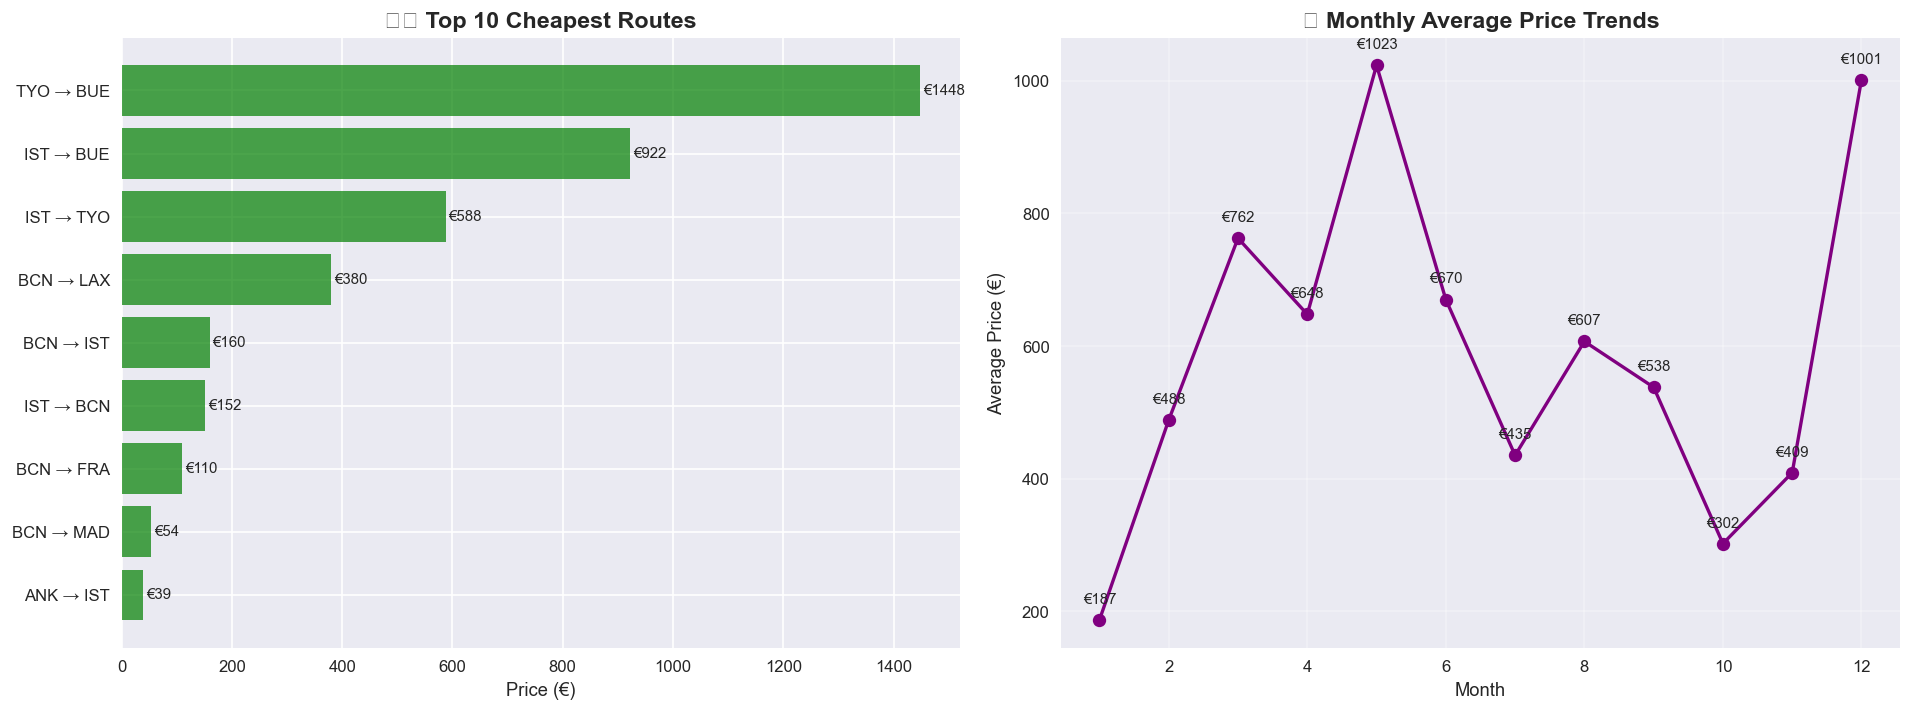

⏰ TIME-SERIES COMPARISON VISUALIZATION


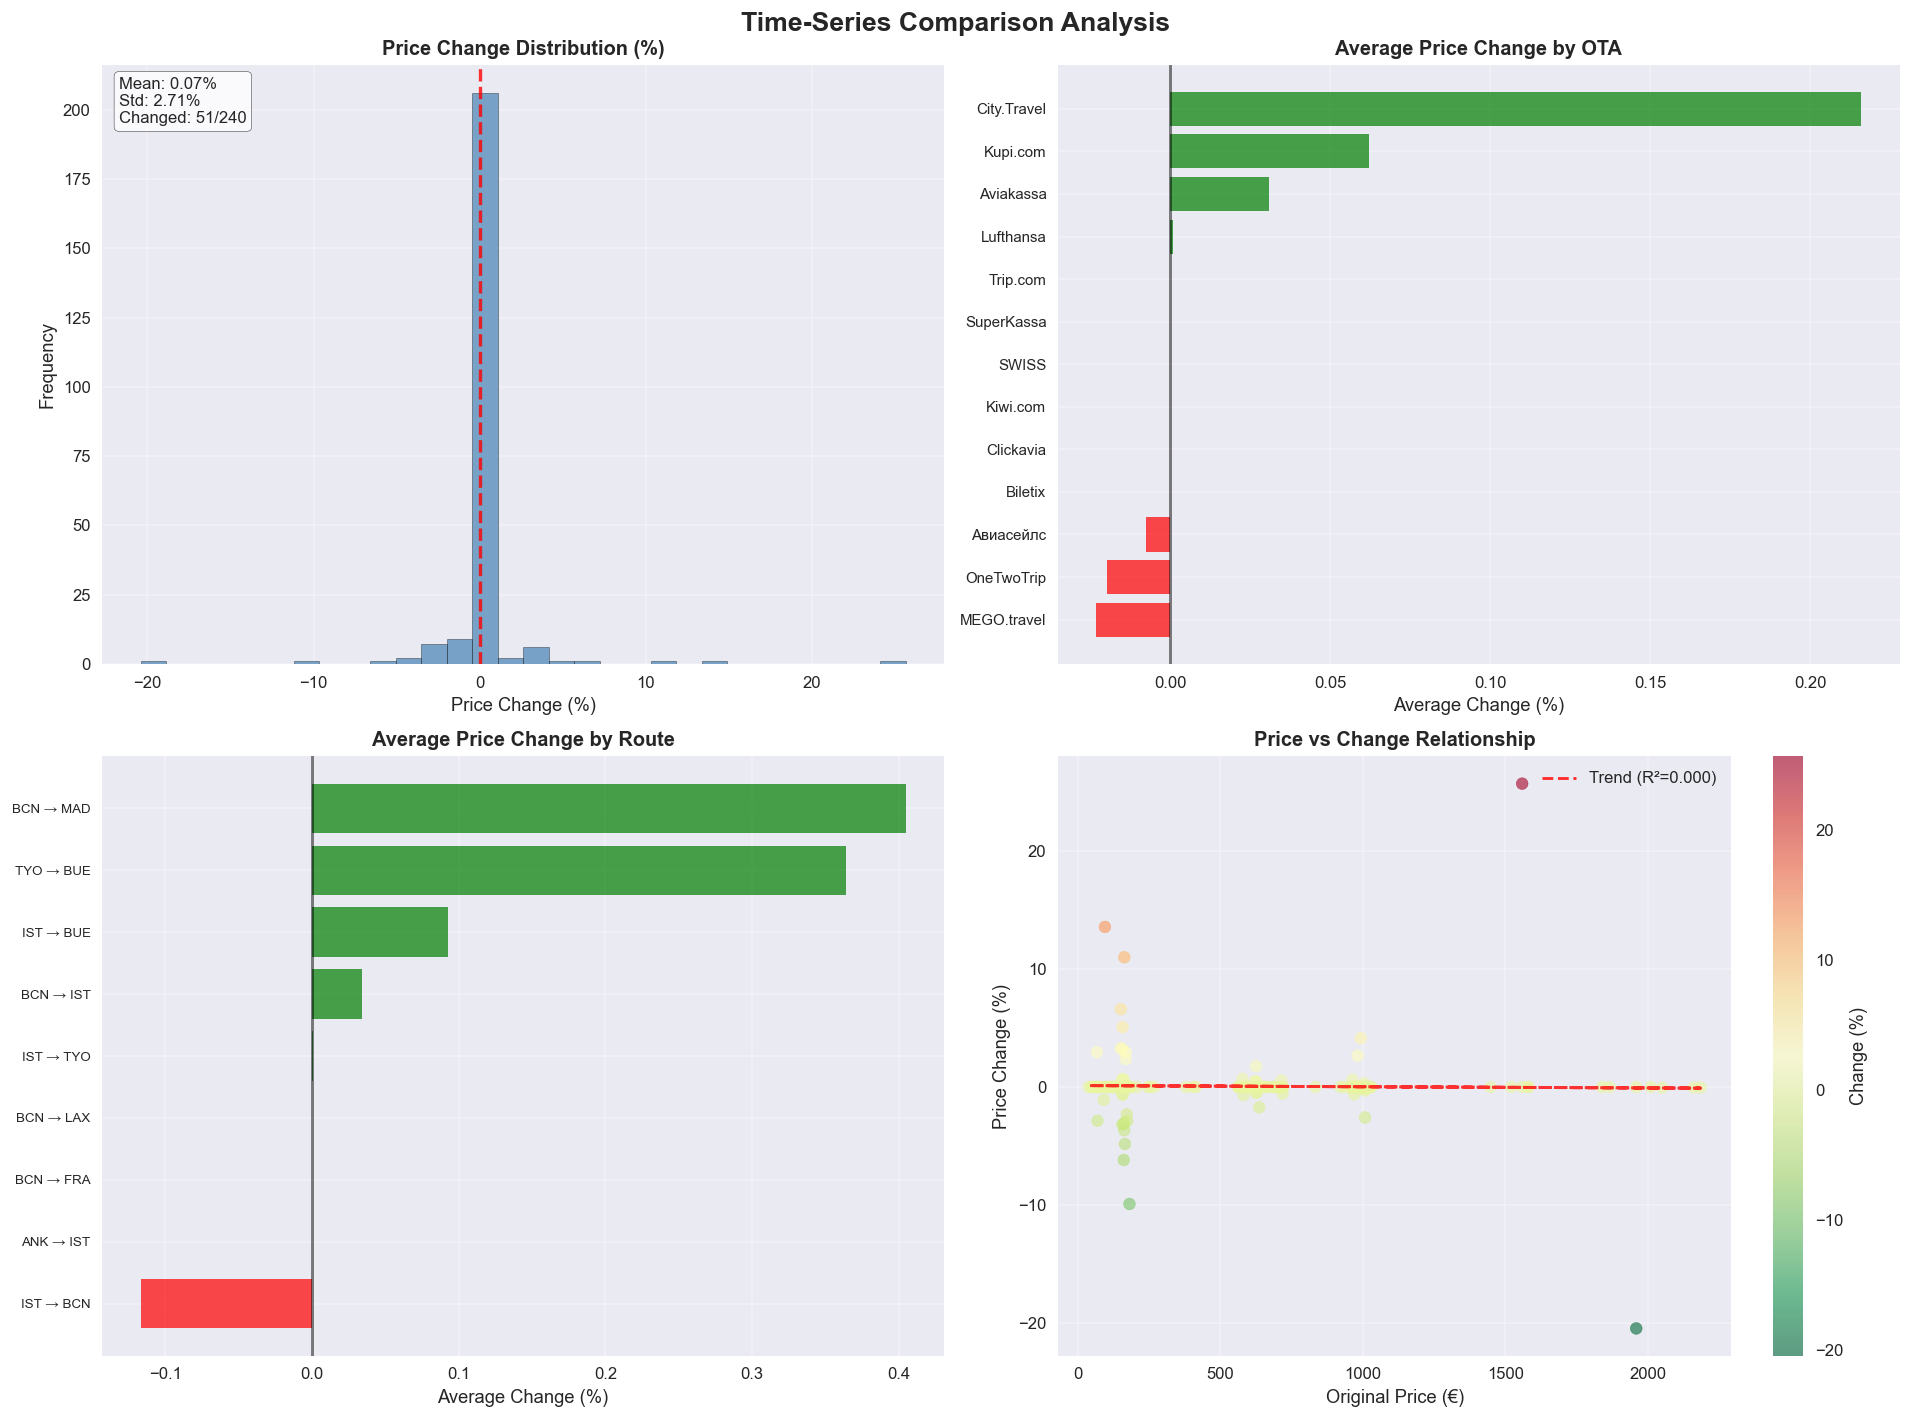


📈 Time-Series Analysis Summary:
   • Comparison period: Latest
   • Flights tracked: 240
   • Price changes detected: 51
   • Average change: 0.07%
   • Volatility (std): 2.71%
   🔺 Significant increases (>5%): 5
   🔻 Significant decreases (<-5%): 3

🚀 Analysis completed! Project ready for daily monitoring.
📊 Dashboard includes 2 snapshot(s)
🎯 Time-series active


In [ ]:
# 2. Route and Date Analysis Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 10 Cheapest Routes
top_routes = route_results.head(10)
bars1 = ax1.barh(range(len(top_routes)), top_routes['cheapest_price'], 
                 color='green', alpha=0.7)
ax1.set_yticks(range(len(top_routes)))
ax1.set_yticklabels(top_routes['route'])
ax1.set_title('✈️ Top 10 Cheapest Routes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Price (€)')

# Add price labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 5, bar.get_y() + bar.get_height()/2,
             f'€{width:.0f}', ha='left', va='center')

# Monthly Price Trends
if not date_results.empty:
    ax2.plot(date_results['month'], date_results['avg_price'], 
             marker='o', linewidth=2, markersize=8, color='purple')
    ax2.set_title('📅 Monthly Average Price Trends', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Average Price (€)')
    ax2.grid(True, alpha=0.3)
    
    # Add price annotations
    for x, y in zip(date_results['month'], date_results['avg_price']):
        ax2.annotate(f'€{y:.0f}', (x, y), textcoords="offset points", 
                    xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Time series comparison visualization 
if len(available_snapshots) > 1:
    print("⏰ TIME SERIES COMPARISON VISUALIZATION")
    print("=" * 45)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Time Series Comparison Analysis', fontsize=16, fontweight='bold')
    
    # Load comparison data if available
    results_dir = Path("analysis_results")
    comparison_files = list(results_dir.glob("detailed_comparison_*.csv"))
    
    if comparison_files:
        latest_comparison = pd.read_csv(sorted(comparison_files)[-1])
        
        # 1. Price change distribution
        ax1 = axes[0, 0]
        price_changes = latest_comparison['change_pct'].dropna()
        ax1.hist(price_changes, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        ax1.axvline(0, color='red', linestyle='--', alpha=0.8, linewidth=2)
        ax1.set_title('Price Change Distribution (%)', fontweight='bold')
        ax1.set_xlabel('Price Change (%)')
        ax1.set_ylabel('Frequency')
        ax1.grid(True, alpha=0.3)
        
        # Add statistics text
        stats_text = f'Mean: {price_changes.mean():.2f}%\nStd: {price_changes.std():.2f}%\nChanged: {len(price_changes[price_changes != 0])}/{len(price_changes)}'
        ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. OTA price change comparison
        ax2 = axes[0, 1]
        ota_changes = latest_comparison.groupby('gate')['change_pct'].mean().sort_values()
        colors = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in ota_changes.values]
        bars = ax2.barh(range(len(ota_changes)), ota_changes.values, color=colors, alpha=0.7)
        ax2.set_yticks(range(len(ota_changes)))
        ax2.set_yticklabels(ota_changes.index, fontsize=9)
        ax2.set_title('Average Price Change by OTA', fontweight='bold')
        ax2.set_xlabel('Average Change (%)')
        ax2.axvline(0, color='black', linestyle='-', alpha=0.5)
        ax2.grid(True, alpha=0.3)
        
        # 3. Route price change comparison
        ax3 = axes[1, 0]
        route_changes = latest_comparison.groupby('route')['change_pct'].mean().sort_values()
        colors = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in route_changes.values]
        bars = ax3.barh(range(len(route_changes)), route_changes.values, color=colors, alpha=0.7)
        ax3.set_yticks(range(len(route_changes)))
        ax3.set_yticklabels(route_changes.index, fontsize=8)
        ax3.set_title('Average Price Change by Route', fontweight='bold')
        ax3.set_xlabel('Average Change (%)')
        ax3.axvline(0, color='black', linestyle='-', alpha=0.5)
        ax3.grid(True, alpha=0.3)
        
        # 4. Price vs change relationship
        ax4 = axes[1, 1]
        scatter = ax4.scatter(latest_comparison['price_eur_old'], latest_comparison['change_pct'], 
                            alpha=0.6, c=latest_comparison['change_pct'], cmap='RdYlGn_r', s=50)
        ax4.set_xlabel('Original Price (€)')
        ax4.set_ylabel('Price Change (%)')
        ax4.set_title('Price vs Change Relationship', fontweight='bold')
        ax4.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax4, label='Change (%)')
        
        # Add trend line
        from scipy import stats
        if len(latest_comparison) > 5:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                latest_comparison['price_eur_old'], latest_comparison['change_pct'])
            line = slope * latest_comparison['price_eur_old'] + intercept
            ax4.plot(latest_comparison['price_eur_old'], line, 'r--', alpha=0.8, 
                    label=f'Trend (R²={r_value**2:.3f})')
            ax4.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print(f"\n📈 Time-Series Analysis Summary:")
        print(f"   • Comparison period: {latest_comparison.columns[0].split('_')[-1] if '_' in str(latest_comparison.columns[0]) else 'Latest'}")
        print(f"   • Flights tracked: {len(latest_comparison):,}")
        print(f"   • Price changes detected: {len(latest_comparison[latest_comparison['price_diff'] != 0]):,}")
        print(f"   • Average change: {latest_comparison['change_pct'].mean():.2f}%")
        print(f"   • Volatility (std): {latest_comparison['change_pct'].std():.2f}%")
        
        # Highlight significant changes
        significant_increases = latest_comparison[latest_comparison['change_pct'] > 5]
        significant_decreases = latest_comparison[latest_comparison['change_pct'] < -5]
        
        if len(significant_increases) > 0:
            print(f"   🔺 Significant increases (>5%): {len(significant_increases)}")
        if len(significant_decreases) > 0:
            print(f"   🔻 Significant decreases (<-5%): {len(significant_decreases)}")
            
    else:
        print("📝 Comparison data not yet available. Run price_comparison_analysis.py first.")
        
else:
    print("⏰ TIME-SERIES COMPARISON")
    print("=" * 30)
    print("📝 Multiple snapshots required for time-series analysis.")
    print("🎯 Current status: Initial data collection completed")
    print("📅 Next step: Collect data tomorrow to enable comparison analysis")
    
    # Show what will be available
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.text(0.5, 0.5, 
            'Time-Series Analysis Dashboard\n\n'
            'Pending Second Snapshot\n\n'
            'This visualization will show:\n'
            '• Price evolution trends\n'
            '• OTA competitive dynamics\n'
            '• Route-level price changes\n'
            '• Market volatility patterns\n\n'
            'Run fetch_prices.py tomorrow to activate!', 
            ha='center', va='center', transform=ax.transAxes, fontsize=14,
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    ax.set_title('Time-Series Analysis Preview', fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.show()

print(f"\n🚀 Analysis completed! Project ready for daily monitoring.")
print(f"📊 Dashboard includes {len(available_snapshots)} snapshot(s)")
print(f"🎯 {'Time-series active' if len(available_snapshots) > 1 else 'Awaiting next snapshot for time-series'}")

## Summary and Key Insights

Through this analysis, I've discovered several important patterns in the flight pricing data:

### OTA Analysis Findings:
- Identified the most frequently appearing online travel agencies
- Compared average pricing strategies across different platforms
- Analyzed price ranges and competitive positioning

### Route Analysis Results:
- Found the most cost-effective flight routes
- Examined price distribution patterns across different destinations
- Identified significant price variations between routes

### Temporal Analysis Insights:
- Observed monthly pricing trends and seasonal variations
- Detected optimal booking periods based on historical data
- Identified patterns that could inform future travel planning



**Personal Takeaway:** This analysis demonstrates the power of combining SQL (via DuckDB) with Python visualization tools. The insights gained can help make more informed travel decisions and identify the best booking strategies. Regular monitoring of these patterns could lead to significant cost savings over time.